# Calculating sums and averages
Workflow that describes how the statistics over a set of intervals / zones can be calculated in Python

Necessary imports

In [1]:
import os
import utils.io as uio
import core.well as cw
from utils.calc_stats import calc_stats2 as calc_stats
from core.well import Project

## Create a wells project

In [2]:
wp = Project(name='MyProject', tops_file='test_data/RokDocTops.xlsx', tops_type='rokdoc')

*Project* also take keywords:
- *working_dir* - the folder where the project is situated
- *project_table* - full or relative path name of a specific formatted .xlsx table that contain important project information
- *log_to_stdout* - if True, logging information is sent to standard output, else to a text file

By default, none of these need to set, and it uses the install directory, toghether with example data and project table there

## Load project table
The project table is a .xlsx file that contain, among other things, which wells and well logs to load, and where to find them.
If some wells have different names for the same well log, you need to *harmonize* the log names so that they are understood correctly in the project.

For example, *Well_F* in case, uses *VSH* as name for shale volume, while the others use *VCL*, to rename from *VSH* to *VCL*, use the following 

In [3]:
#well_table = uio.project_wells(wp.project_table, wp.working_dir)
wells = wp.load_all_wells({'VCL': ['VSH']})

0 WELL_C test_data/Well C.las
Renaming log from DEPT to depth
Renaming log from depth to depth
1 WELL_F test_data/Well F.las
Renaming log from DEPTH to depth
Renaming log from VSH to VCL
Renaming log from depth to depth


['rho_dry', 'vs', 'depth', 'phie', 'vp_dry', 'vp', 'vs_dry', 'vcl']
['vp_so08', 'vs_sg08', 'rho_dry', 'vp_sg08', 'rho_so08', 'depth', 'phie', 'vp_dry', 'rho_sg08', 'vs_dry', 'vs_so08', 'sw', 'vcl']


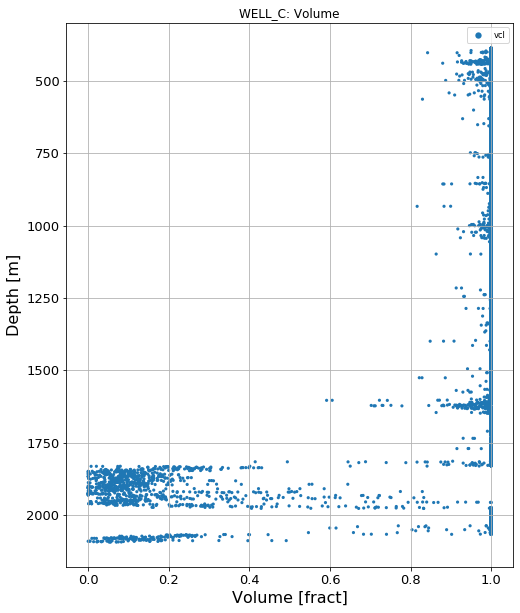

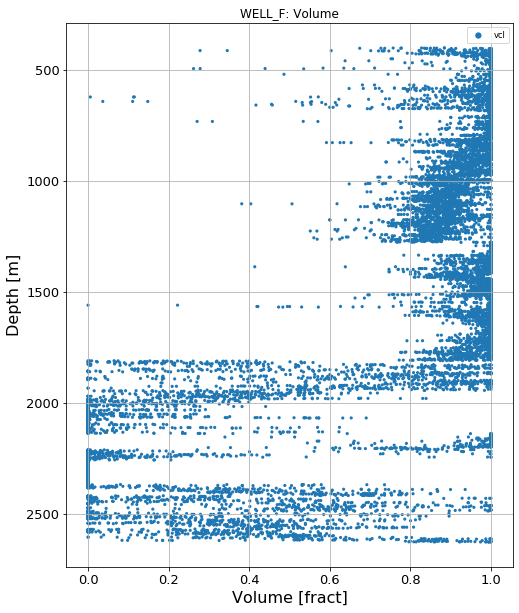

In [4]:
for well in wells.values():
    print(well.log_names())
    well.depth_plot('Volume')

## Load tops
Load file with well tops. They can be in format exported from Petrel (use uio.read_petrel_tops()), npd.no (use uio.read_npd_tops()), or RokDoc (use uio.read_rokdoc_tops())


In [ ]:
tops = uio.read_tops(wp.tops_file, frmt=wp.tops_type)
#print('The tops file contains following wells and tops:')
for well in list(tops.keys()):
    print(' Well: {}'.format(well))
#    for ttop in list(tops[well].keys()):
#        print('  - {}'.format(ttop))

   # Calculate RokDoc compatible Sums & Averages
  This functionality is useful when you want to analyze the statistics of several formations / intervals across multiple wells (.las files).
  The results is saved as an .xlsx spreadsheet, with statistics of the rock properties. To be read by RokDoc, it has to be converted to .xls

Tell python where to save the results, where to find the wells, and the tops file

If the .xlsx file exists, it will be appended to
If you want to save the results, or load the data from, elsewhere on your file system, please provide the full path name, using "forward slashes"
In the folder of where the .xlsx file is situated, all QC plots will be saved. Their name will end with the below 'tag'

In [ ]:
rd_file = 'results_folder/RokDoc_SumsAverages_from_python.xlsx'

tag = 'my_test'

Modify the project_table.xlsx so that it points to the wells; Well_A, Well_B and Well_C

<img src="images/Annotation 2020-02-11 093608.png" />


Log names under each log types *P velocity*, *S velocity*, *Density*, *Porosity*, and *Volume* must be specified.

Multiple log names can be specified under each log type, but only one log per log type can be used in the statistics.

Therefore we need a table to specify which log to use under each log type


In [ ]:
log_table = {'P velocity': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vcl'}

Define the formations / intervals you like to calculate the statistics over.
 - 'name' is an arbitrary name used when writing the sums & averages to file
 - 'tops' is a list of formation / interval names of the top and base that defines the interval of interest. For the calculation to work, these names have to exist in the above defined tops_file, for the given wells. 

In [ ]:
intervals_sands = [
            {'name': 'Sand H',
             'tops': ['Top H', 'Base H']},        
            {'name': 'Sand F',
             'tops': ['Top F', 'Base F']},
            {'name': 'Sand E',
             'tops': ['Top E', 'Top F']},
            {'name': 'Sand D',
             'tops': ['Top D', 'Top E']},
            {'name': 'Sand C',
             'tops': ['Top C', 'Top D']}
]
intervals_shales = [
    {'name': 'Shale C',
         'tops': ['Top C', 'Top D']},
    {'name': 'Shale G',
         'tops': ['Top G', 'Top H']}
]

Test to see if the above intervals are present in all wells

In [ ]:
for intervals in [intervals_sands, intervals_shales]:
    for key in list(wells.keys()):
        for top_name in [x['tops'][0].upper() for x in intervals]:
            if top_name not in list(tops[key].keys()):
                print('Top: {}, not present in well {}'.format(top_name, key))
        for base_name in [x['tops'][1].upper() for x in intervals]:
            if base_name not in list(tops[key].keys()):
                print('Base: {}, not present in well {}'.format(base_name, key))

Define the cut offs that are used to classify the data (e.g. sands or shales).
The statistics will only be calculated within each interval, where the cut off is valid
The log names (e.g. *vcl*) corresponding to a log type (e.g. *Volume*) must exist in the .las files

In [ ]:
cutoffs_sands = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}
cutoffs_shales = {'Volume': ['>', 0.5], 'Porosity': ['<', 0.1]}

Run the calculation of the statistics

In [ ]:
calc_stats(wells, log_table, tops, intervals_sands, cutoffs_sands, 
              rokdoc_output=rd_file,
              working_dir=os.path.join(wp.working_dir, 'results_folder'),
              suffix=tag)

In [ ]:
cw.calc_stats(well_table, tops, intervals_shales, cutoffs_shales, 
              rokdoc_output=rd_file,
              working_dir=os.path.join(wp.working_dir, 'results_folder'),
              suffix=tag)